# SATB2
[Glass syndrome (GLASS)](https://omim.org/entry/612313) is caused by heterozygous interstitial deletion on chromosome 2q32-q33. The disorder can also be caused by heterozygous mutation in the SATB2 gene (608148), which is within the Glass syndrome chromosome region.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.4


### SATB2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NKX6-2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SATB2'
mane_tx_id = 'NM_001172509.2'
mane_protein_id = 'NP_001165980.1' # DNA-binding protein SATB2
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets from {gene_symbol}')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 158 phenopackets from SATB2
Individuals Processed: 100%|██████████| 158/158 [00:36<00:00,  4.34 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
157,Global developmental delay
135,Abnormality of the dentition
107,Intellectual disability
89,Feeding difficulties in infancy
89,Delayed ability to walk
75,Delayed speech and language development
70,Cleft palate
50,Brain imaging abnormality
44,Growth delay
33,Reduced bone mineral density


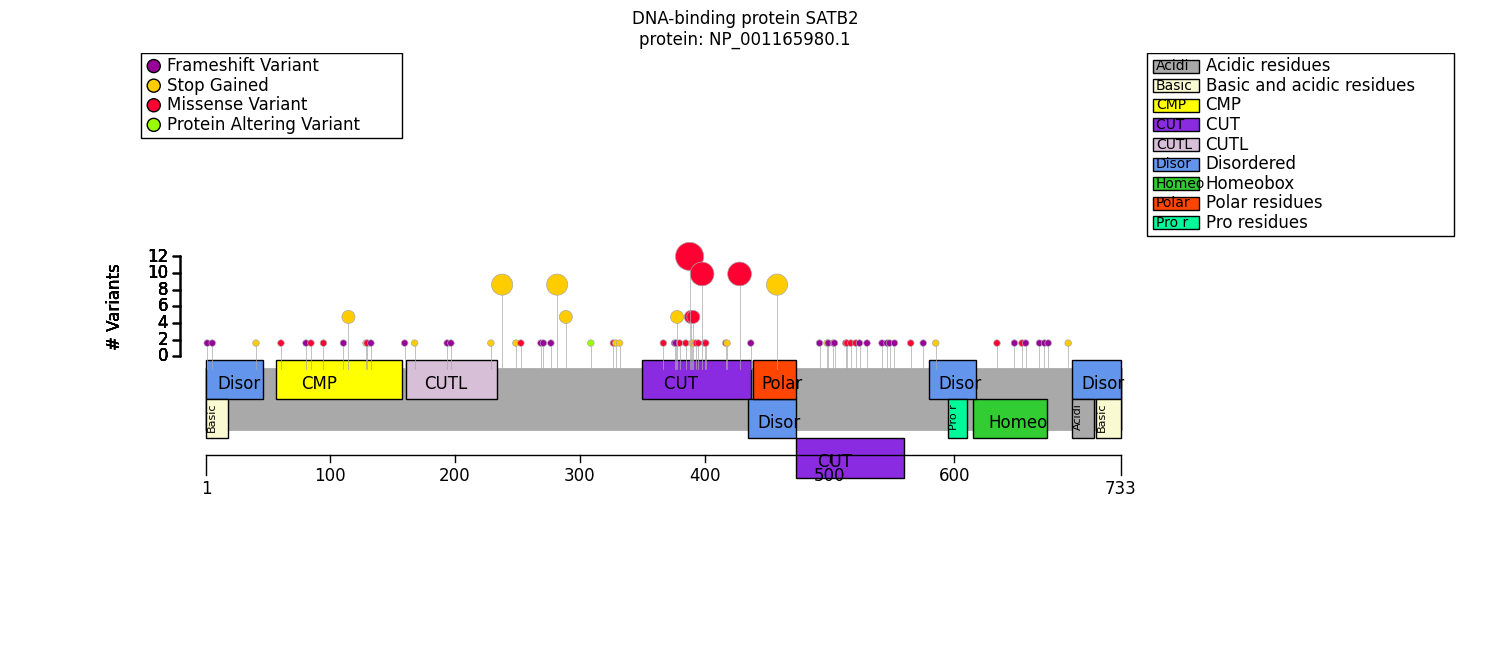

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

satb2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
satb2_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,2 - 47,p.Arg4GlufsTer68; p.Ser7LysfsTer68; p.Gly42Ter
2,Basic and acidic residues,Compositional bias,2 - 19,p.Arg4GlufsTer68; p.Ser7LysfsTer68
10,CMP,Domain,58 - 158,p.Val62Asp; p.Ala112ProfsTer6; p.Val131Glu; p.Ala134HisfsTer17; p.Gly116Ter; p.Ala82GlyfsTer30; p.Tyr130Ter; p.Leu86Arg; p.Gly116Arg; p.Leu96Arg
4,CUTL,Domain,162 - 234,p.Lys230Ter; p.Gln169Ter; p.Cys195LeufsTer14; p.Gln199GlufsTer9
46,CUT 1,DNA binding,351 - 437,p.Gly392Glu; p.Arg399His; p.Val368Phe; p.Glu396Gln; p.Arg429Gln; p.Arg389Cys; p.Glu402Lys; p.Arg429Ter; p.Arg399LeufsTer14; p.Gln379Ter; p.Gly392Arg; p.Thr390Ile; p.Gln419Ter; p.Ser378TyrfsTer36; p.Ala386Val; p.Arg399Pro; p.Leu394Ser; p.Ser378ProfsTer18; p.Arg399Leu; p.Glu402ArgfsTer35; p.Arg389Leu; p.Gln391Ter; p.Val381Gly; p.Met418Arg; p.Gln379Pro
7,Disordered,Region,436 - 473,p.Arg459Ter; p.Arg439GlyfsTer38
6,Polar residues,Compositional bias,440 - 473,p.Arg459Ter
15,CUT 2,DNA binding,474 - 560,p.Leu547PhefsTer77; p.Asp553MetfsTer71; p.Gln549SerfsTer75; p.Val500CysfsTer46; p.Arg522Cys; p.Asn531LysfsTer21; p.Glu525GlyfsTer21; p.Arg543AlafsTer3; p.Gln514Arg; p.Phe505LysfsTer10; p.Lys499Ter; p.Gln493ArgfsTer19; p.Phe505LeufsTer41; p.Gly515Ser; p.Cys518Trp
1,Disordered,Region,581 - 617,p.Gln586Ter
0,Pro residues,Compositional bias,596 - 610,


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
22,SO:1000029_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal deletion
10,2_199348709_199348709_G_A,c.1165C>T (p.Arg389Cys),7,missense
6,2_199349159_199349159_G_A,c.715C>T (p.Arg239Ter),7,stop gained
6,SO:1000044_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal_translocation
6,2_199328709_199328709_G_A,c.1375C>T (p.Arg459Ter),8,stop gained
6,2_199349027_199349027_G_A,c.847C>T (p.Arg283Ter),7,stop gained
4,2_199328888_199328888_C_T,c.1196G>A (p.Arg399His),8,missense
4,2_199328798_199328798_C_T,c.1286G>A (p.Arg429Gln),8,missense
4,2_199328799_199328799_G_A,c.1285C>T (p.Arg429Ter),8,stop gained
3,SO:1000037_HGNC:21637_SATB2,SV involving SATB2 (p.?),,chromosomal duplication


## Genotype-Phenotype Correlation (GPC) Analysis


In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
   a_predicate=is_missense,
   b_predicate=~is_missense,
   a_label="Missense",
   b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,2
HMF03,Skipping term because of a child term with the same individual counts,7
HMF08,Skipping general term,14
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,4


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
Cleft palate [HP:0000175],11/49 (22%),59/105 (56%),0.001993,0.000111
Feeding difficulties in infancy [HP:0008872],24/40 (60%),65/90 (72%),1.000000,0.219640
Delayed ability to walk [HP:0031936],33/41 (80%),56/80 (70%),1.000000,0.277877
Abnormality of the dentition [HP:0000164],39/40 (98%),96/97 (99%),1.000000,0.500215
Orofacial cleft [HP:0000202],11/11 (100%),59/59 (100%),1.000000,1.000000
Abnormal palate morphology [HP:0000174],11/11 (100%),59/59 (100%),1.000000,1.000000
Brain imaging abnormality [HP:0410263],18/39 (46%),32/69 (46%),1.000000,1.000000
Language impairment [HP:0002463],20/20 (100%),55/55 (100%),1.000000,1.000000
Abnormal communication [HP:0034434],20/20 (100%),55/55 (100%),1.000000,1.000000
Abnormal speech pattern [HP:0002167],20/20 (100%),55/55 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.predicate import protein_feature

uld = protein_feature(feature_id="Homeobox", protein_metadata=protein_meta)

uld_predicate = monoallelic_classifier(
   a_predicate=uld,
   b_predicate=~uld,
   a_label="ULD",
   b_label="Other"
)
uld_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=uld_predicate,
    pheno_clfs=pheno_clfs,
)


summarize_hpo_analysis(hpo=hpo, result=uld_result)


Allele group,ULD,Other,Corrected p values,p values
Cleft palate [HP:0000175],4/6 (67%),66/148 (45%),1.0,0.411718
Delayed ability to walk [HP:0031936],3/5 (60%),86/116 (74%),1.0,0.606967
Brain imaging abnormality [HP:0410263],3/5 (60%),47/103 (46%),1.0,0.660905
Feeding difficulties in infancy [HP:0008872],5/6 (83%),84/124 (68%),1.0,0.664264
Language impairment [HP:0002463],3/3 (100%),72/72 (100%),1.0,1.000000
Abnormal communication [HP:0034434],3/3 (100%),72/72 (100%),1.0,1.000000
Abnormal speech pattern [HP:0002167],3/3 (100%),72/72 (100%),1.0,1.000000
Delayed speech and language development [HP:0000750],3/3 (100%),72/75 (96%),1.0,1.000000
Delayed gross motor development [HP:0002194],3/3 (100%),86/86 (100%),1.0,1.000000
Orofacial cleft [HP:0000202],4/4 (100%),66/66 (100%),1.0,1.000000


In [12]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Feeding difficulties in infancy [HP:0008872],31/53 (58%),58/77 (75%),0.988717,0.054929
Cleft palate [HP:0000175],24/62 (39%),43/88 (49%),1.000000,0.245526
Delayed ability to walk [HP:0031936],31/45 (69%),57/75 (76%),1.000000,0.402722
Brain imaging abnormality [HP:0410263],19/46 (41%),31/61 (51%),1.000000,0.433938
Abnormality of the dentition [HP:0000164],54/54 (100%),79/81 (98%),1.000000,0.516418
Delayed speech and language development [HP:0000750],33/35 (94%),42/43 (98%),1.000000,0.584560
Orofacial cleft [HP:0000202],24/24 (100%),43/43 (100%),1.000000,1.000000
Abnormal palate morphology [HP:0000174],24/24 (100%),43/43 (100%),1.000000,1.000000
Delayed gross motor development [HP:0002194],31/31 (100%),57/57 (100%),1.000000,1.000000
Feeding difficulties [HP:0011968],31/31 (100%),58/58 (100%),1.000000,1.000000


In [13]:
ablation = variant_effect(effect=VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id)

ablation_clf = monoallelic_classifier(
    a_predicate=ablation,
    b_predicate=~ablation,
    a_label="transcript ablation",
    b_label="other"
)
ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=ablation_result)


Allele group,transcript ablation,other,Corrected p values,p values
Feeding difficulties in infancy [HP:0008872],12/22 (55%),77/108 (71%),1.0,0.136965
Delayed ability to walk [HP:0031936],10/15 (67%),79/106 (75%),1.0,0.538765
Brain imaging abnormality [HP:0410263],4/11 (36%),46/97 (47%),1.0,0.540355
Cleft palate [HP:0000175],11/22 (50%),59/132 (45%),1.0,0.652093
Delayed gross motor development [HP:0002194],10/10 (100%),79/79 (100%),1.0,1.000000
Orofacial cleft [HP:0000202],11/11 (100%),59/59 (100%),1.0,1.000000
Abnormal palate morphology [HP:0000174],11/11 (100%),59/59 (100%),1.0,1.000000
Feeding difficulties [HP:0011968],12/12 (100%),77/77 (100%),1.0,1.000000
Intellectual disability [HP:0001249],13/13 (100%),94/94 (100%),1.0,1.000000
Abnormality of the dentition [HP:0000164],18/18 (100%),117/119 (98%),1.0,1.000000


In [14]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer
from gpsea.analysis.pscore.stats import MannWhitneyStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis

score_statistic = MannWhitneyStatistic()
score_analysis = PhenotypeScoreAnalysis(
    score_statistic=score_statistic,
)

pheno_scorer = DeVriesPhenotypeScorer(hpo)
result = score_analysis.compare_genotype_vs_phenotype_score(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_scorer=pheno_scorer,
)
result.pval

0.5113126322400692

# Summary

In [15]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=uld_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=ablation_result,
    ),
)

caption="""). Individuals with large chromosomal deletions were diagnosedat earlier ages (mean 2.5 years, p ≤ 0.0006). Individuals with missense ordisruptive pathogenic variants were more commonly reported to havesialorrhea (p = 0.0115), and those with large deletions were more likelyto have a history of growth retardation (p = 0.0033)
The authors reported a higher prevalence of chronic mucocutanous candidiasis with the variant Arg357Ter than with other 
    variants. We did not identify a significant difference in prevalence \\cite{PMID_29436146}"""

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=fet_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption)


In [16]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [17]:
summarizer.process_latex(report=report, protein_fig=satb2_fig)

Figure saved to ../../supplement/img/SATB2_protein_diagram-draft.pdf
Output to ../../supplement/tex/SATB2_summary_draft.tex
